Michael Buchwitz, 28-March-2023

# How to access, read and process satellite CO2 and CH4 Level 2 products

This is a Jupyter Notebook illustrating how to access, read and process Greenhouse Gas (GHG) carbon dioxide (CO2) and methane (CH4) data products as generated in the framework of the Copernicus Climate Change Service (C3S) project C3S2_312a_Lot2. 

The data products are retrieved from satellite radiance measurements using appropriate retrieval algorithms. 
Most of these algorithms have been developed in the past within the Climate Change Initiative (CCI) of the European Space Agency (ESA). These algorithms are now used to operationally generate the corresponding data products within the European Union (EU) C3S project. The data products are freely available for all interested users from the Copernicus Climate Data Store (CDS, https://cds.climate.copernicus.eu/).

In project C3S2_312a_Lot2 several satellite-derived Essential Climate Variable (ECV) atmospheric data products are generated for GHGs (CO2 and CH4), aerosols and ozone. This Jupyter Notebook (JN) focusses on GHG Level 2 (L2) products. The other products are covered by separate JNs. L2 products contain retrieved parameters for individual satellite ground pixels (footprints). In contrast to Level 3 products, the L2 products are not averaged in space and time, but provided information at sensor resolution, sampling and time.

Here it will be shown how the data products can be obtained from the CDS and how they can be processed to extract important information and how to visualize this information.

Within this JN, we use two types of satellite-based GHG L2 products: (i) Column-averaged dry-air mole fractions of CO2 and CH4, denoted XCO2 and XCH4 and (ii) mid-tropospheric columns of CO2 and CH4. The unit of the XCO2 and CO2 products is parts per million (ppm) and the unit of the XCH4 and CH4 products is parts per billion (ppb). The XCO2 and XCH4 products are derived from SCIAMACHY/ENVISAT, GOSAT, GOSAT-2 and OCO-2. The mid-tropospheric CO2 and CH4 products are derived from IASI on Metop-A and Metop-B and for CO2 also from AIRS.

This JN has been tested using the latest versions of the satellite data products collectively referred to as "Climate Data Record 6" (CDR6). CDR6 covers the time period 2003-2021 but temporal coverage of a given product depends on the availability of the underlying satellite data. The L2 products are daily files in NetCDF format. As the data product format has not changed in recent years it is possible to read and process also earlier versions of the data products. The products are global but daily spatial coverage is sparse due to the sampling of the satellite data and strict quality filtering (e.g., to minimize the impact of clouds).

This document is provided “as is” and no guarantee of warranty is given that the content is fit for any particular purpose.
The users thereof use this document at their sole risk and liability.

## How to get the satellite data products:

Each satellite-derived CO2 or CH4 data product as generated in C3S project C3S2_312a_Lot2 has a unique product identifier (ID). The product IDs of all Level 2 products are listed below (see variable "product_id" in function "get_product_paras").

All L2 products are provided as daily NetCDF files.

On the CDS website all products can be selected manually by clicking on the relevant entries:

For CO2 see: 
https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-carbon-dioxide?tab=form.

For CH4 see:
https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-methane?tab=form.

User can select a product and download it.

However, depending on application, it may be more convenient for user to access the products via the CDS API (cdsapi). Below in Section "Data download from the CDS via the cdsapi" we describe how to do this.

Independently of how the L2 data products have been obtained, we assume here that the downloaded L2 files are stored in subdirectories, which correspond to the following structure:

.\L2_files\{product_id}\

Here {product_id} is the product ID (see "product_id" in "get_product_paras"). Example: We assume that the XCO2_EMMA product files are stored in sub-directory .\L2_files\XCO2_EMMA\.

### Data download from the CDS via the cdsapi:

How to use the CDS API is describe here: https://cds.climate.copernicus.eu/api-how-to. This includes how to install the CDS API key on your system and how to add the relevant URL.

The CDS API (cdsapi) needs to be installed on your system, e.g., via the following command: pip install cdsapi.

Statement "import cdsapi" needs to be added to make the functionallity of the CDS API available (see section "Imports"). 

How to activate data download via cdsapi please see section "Initial user input". In short:

- Download is activated via: do_download_L2_data_via_cdsapi = 1.

- Product selection is done by setting variables product_id and and product_ver. Example: product_id = 'XCO2_EMMA'; product_ver = '4.4'

- After data download the following file will be stored in your local directory: download.zip.

- Unzip the file and move the downloaded daily NetCDF file to a subdirectory, which correspond to the following structure: .\L2_files\{product_id}\, where {product_id} is the product ID (see "product_id" in function "get_product_paras"). Example: We assume here that the XCO2_EMMA product files are stored in sub-directory .\L2_files\XCO2_EMMA\.

The downloaded product files will then be used by deactivating the download: do_download_L2_data_via_cdsapi = 0. This disables data download and enables reading and processing the data.

## How to access, read and process the satellite data with Python:

In the following, Phython 3 code is provided to read and process the satellite data.

It is assumed that Python and Jupyter Notebook (JN) is installed on your computer, e.g., using the Anaconda distribution
(https://www.anaconda.com/products/distribution).

The code starts with importing several modules as needed to run this JN. See section "Imports".

## Imports:

In [10]:
import os
import os.path
from netCDF4 import Dataset
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Polygon as patches_Polygon
import pandas as pd
import cdsapi # pip install cdsapi

## Functions:

In [2]:
####################################################
# Read daily product file to obtain most relevant parameters:
# Input: 
# main_product: 'XCO2' or 'XCH4', 
# prod_format: 'cci_iasi' for IASI data or any other string 
# for data for other satellites, e.g., 'cci'
# in_file: satellite Level 2 file name (including path if needed),
# year, month, day: day of interest
# product_id: Product ID
# Output: 
# Satellite data for each ground pixel of day of interest:
# sat_data:
#    xgas: retrieved XCO2 value (in ppm) or XCH4 value (in ppb)
#    xgas_err: 1-sigma uncertainty of XCO2 (in ppm) or XCH4 (in ppb)
#    latc: center latitude of ground pixel (-90 to +90)
#    lonc: center longitude of ground pixel (-180 to +180)
#    time: time in seconds since 1970-01-01 00:00:00
#    emma_pro_id: value of median_processor_id from EMMA file
# pre_lev: Vertical profile of pressure levels (in hPa)
# pre_wei: Vertical profile of pressure weights (dimensionless)
# gas_apri: A priori vertical profile of CO2 (in ppm) or CH4 (in ppb)
# gas_ak: Averaging kernel profile for XCO2 or XCH4 (dimensionless)
# Note: Listed numerical values are for illustration only
def read_L2_file(main_product, prod_format, in_file, year, month, day, product_id):
   mod_name = 'read_L2_file'
   w_gas = main_product
   sat_data  = None   # Init output
   pre_lev   = None
   pre_wei   = None
   gas_apri  = None
   gas_ak    = None
   emma_pro_str = None
   if ((w_gas != 'XCO2') & (w_gas != 'XCH4')):
      print('* '+mod_name+': ERROR: w_gas not implemented: ', w_gas)
      return(sat_data, pre_lev, pre_wei, gas_apri, gas_ak)
   print('* '+mod_name+': Trying to read: ', in_file)   
   if ((os.path.exists(in_file) == True)):
      print('* '+mod_name+': reading: ', in_file)
      ds = Dataset(in_file)
      aa_latc = ds.variables['latitude'][:]
      nn_read = len(aa_latc)
      print('* '+mod_name+': nn_read: ', nn_read)
      if prod_format == 'cci_iasi':
         if w_gas == 'XCO2':
            aa_qf  = ds.variables['co2_quality_flag'][:]
            aa_gas = ds.variables['co2'][:] # ppm
            aa_gas_err = ds.variables['co2_uncertainty'][:] # ppm
            #aa_gas_apri = ds.variables['co2_profile_apriori'][:]
            aa_gas_ak   = ds.variables['co2_averaging_kernel'][:]
            aa_gas_apri = aa_gas_ak*0.0
         if w_gas == 'XCH4':
            aa_qf  = ds.variables['ch4_quality_flag'][:]
            aa_gas = ds.variables['ch4'][:] # ppb
            aa_gas_err = ds.variables['ch4_uncertainty'][:] # ppb
            #aa_gas_apri = ds.variables['ch4_profile_apriori'][:]
            aa_gas_ak   = ds.variables['ch4_averaging_kernel'][:]
            aa_gas_apri = aa_gas_ak*0.0
      else: # prod_format == 'cci'
         if w_gas == 'XCO2':
            aa_qf  = ds.variables['xco2_quality_flag'][:]
            aa_gas = ds.variables['xco2'][:] # ppm
            aa_gas_err = ds.variables['xco2_uncertainty'][:] # ppm
            aa_gas_apri = ds.variables['co2_profile_apriori'][:]
            aa_gas_ak   = ds.variables['xco2_averaging_kernel'][:]
         if w_gas == 'XCH4':
            aa_qf  = ds.variables['xch4_quality_flag'][:]
            aa_gas = ds.variables['xch4'][:] # ppb
            aa_gas_err = ds.variables['xch4_uncertainty'][:] # ppb
            aa_gas_apri = ds.variables['ch4_profile_apriori'][:]
            aa_gas_ak   = ds.variables['xch4_averaging_kernel'][:]
      emma_pro_id_OK = 0      
      emma_pro_str = 'not_defined'
      if ((product_id == 'XCO2_EMMA') | (product_id == 'XCH4_EMMA')):
         aa_emma_pro_id = ds.variables['median_processor_id'][:]
         emma_pro_str   = ds.variables['median_processor_id'].comment[:]
         emma_pro_id_OK = 1
         if 1 == 0:
            print('* --------------------------------------------')
            print('* Algorithm related information as given in EMMA file:')
            #print(ds.variables['median_processor_id'].comment[:])
            print(emma_pro_str)
            print('* --------------------------------------------')
      aa_pre_lev  = ds.variables['pressure_levels'][:]
      aa_pre_wei  = ds.variables['pressure_weight'][:]
      if 1 == 0: # profiles from 0=surface to n_lev=top-of-atmosphere
         print('* aa_pre_lev.shape: ',  aa_pre_lev.shape)  # (640, 11) (n_lev, n_obs) 
         print('* aa_pre_wei.shape: ',  aa_pre_wei.shape)  # (640, 10) default=one less
         print('* aa_gas_apri.shape: ', aa_gas_apri.shape) # (640, 10)
         print('* aa_gas_ak.shape: ',   aa_gas_ak.shape)   # (640, 10)
      (idg)   = ((aa_qf < 0.5)).nonzero() # return only good quality data
      a_qf    = aa_qf[(idg)]
      nn_good = len(a_qf)
      print('* '+mod_name+': nn_good: ', nn_good)
      aa_time  = ds.variables['time'][:] # seconds since 1970-01-01 00:00:00
      if (nn_good > 0):
         aa_lonc = ds.variables['longitude'][:] # -180 to +180
         # --------------
         latc      = aa_latc[(idg)]
         lonc      = aa_lonc[(idg)]
         xgas      = aa_gas[(idg)]
         xgas_err  = aa_gas_err[(idg)]
         time      = aa_time[(idg)]
         pre_lev   = aa_pre_lev[(idg),:]
         pre_wei   = aa_pre_wei[(idg),:]
         gas_apri  = aa_gas_apri[(idg),:]
         gas_ak    = aa_gas_ak[(idg),:]
         pre_lev   = pre_lev[0][:][:]
         pre_wei   = pre_wei[0][:][:]
         gas_apri  = gas_apri[0][:][:]
         gas_ak    = gas_ak[0][:][:]
         if emma_pro_id_OK == 1:
            emma_pro_id = aa_emma_pro_id[(idg)]
         else:
            emma_pro_id = np.zeros((nn_good,), dtype=int) - 1 # all entries are: -1
         sat_data  = pd.DataFrame({'gas': xgas, 'gas_err': xgas_err, 'latc': latc, 'lonc': lonc, 'time': time, 'emma_pro_id': emma_pro_id})       
   print('* ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
   return(sat_data, pre_lev, pre_wei, gas_apri, gas_ak, emma_pro_str)  # May be None
####################################################
# ... read_L2_file
####################################################

# ######################################################################## 
# Get additional parameters for desired satellite data product
# including those needed to download data from the CDS
# ######################################################################## 
def get_product_paras(product_id):

   # Init output paras:
   main_product             = None
   xghg_str1                = None
   xghg_str2                = None
   prod_format              = None
   prod_file_id             = None
   sensor_and_algorithm_str = None
   product_variable         = None
   prod_year_start          = None
   prod_year_end            = None

   # Set additional parameters per product: 
   # --------------------------------------------------
   if product_id == 'XCO2_EMMA':
      main_product = 'XCO2'
      xghg_str1    = 'XCO$_2$'
      xghg_str2    = 'Column-averaged CO$_2$, XCO$_2$ [ppm]'
      prod_format  = 'cci'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-MERGED-MERGED-EMMA-DAILY-'
      sensor_and_algorithm_str = 'merged_emma'
      product_variable = 'xco2'
      prod_year_start  = 2003; prod_year_end = 2021
   # --------------------------------------------------
   if product_id == 'CO2_SCI_BESD':
      main_product = 'XCO2'
      xghg_str1    = 'XCO$_2$'
      xghg_str2    = 'Column-averaged CO$_2$, XCO$_2$ [ppm]'
      prod_format  = 'cci'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-SCIAMACHY-ENVISAT-BESD-DAILY-'
      sensor_and_algorithm_str = 'sciamachy_besd'
      product_variable = 'xco2'
      prod_year_start  = 2003; prod_year_end = 2012
   # --------------------------------------------------
   if product_id == 'CO2_SCI_WFMD':
      main_product = 'XCO2'
      xghg_str1    = 'XCO$_2$'
      xghg_str2    = 'Column-averaged CO$_2$, XCO$_2$ [ppm]'
      prod_format  = 'cci'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-SCIAMACHY-ENVISAT-WFMD-DAILY-'
      sensor_and_algorithm_str = 'sciamachy_wfmd'
      product_variable = 'xco2'
      prod_year_start  = 2003; prod_year_end = 2012
   # --------------------------------------------------
   if product_id == 'CO2_GOS_OCFP':
      main_product = 'XCO2'
      xghg_str1    = 'XCO$_2$'
      xghg_str2    = 'Column-averaged CO$_2$, XCO$_2$ [ppm]'
      prod_format  = 'cci'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-TANSO-GOSAT-OCFP-DAILY-'
      sensor_and_algorithm_str = 'tanso_fts_ocfp'
      product_variable = 'xco2'
      prod_year_start  = 2009; prod_year_end = 2020 # until mid 2020
   # --------------------------------------------------
   if product_id == 'CO2_GOS_SRFP':
      main_product = 'XCO2'
      xghg_str1    = 'XCO$_2$'
      xghg_str2    = 'Column-averaged CO$_2$, XCO$_2$ [ppm]'
      prod_format  = 'cci'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-TANSO-GOSAT-SRFP-DAILY-'
      sensor_and_algorithm_str = 'tanso_fts_srfp'
      product_variable = 'xco2'
      prod_year_start  = 2009; prod_year_end = 2021
   # --------------------------------------------------
   if product_id == 'CO2_GO2_SRFP':
      main_product = 'XCO2'
      xghg_str1    = 'XCO$_2$'
      xghg_str2    = 'Column-averaged CO$_2$, XCO$_2$ [ppm]'
      prod_format  = 'cci'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-TANSO2-GOSAT2-SRFP-DAILY-'
      sensor_and_algorithm_str = 'tanso2_fts2_srfp'
      product_variable = 'xco2'
      prod_year_start  = 2019; prod_year_end = 2021
   # --------------------------------------------------
   if product_id == 'CO2_AIR_NLIS':
      main_product = 'XCO2'
      xghg_str1    = 'CO$_2$'
      xghg_str2    = 'Mid-tropospheric CO$_2$ [ppm]'
      prod_format  = 'cci_iasi'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-AIRS-AQUA-NLIS-DAILY-'
      sensor_and_algorithm_str = 'airs_nlis'
      product_variable = 'co2'
      prod_year_start  = 2003; prod_year_end = 2007
   # --------------------------------------------------
   if product_id == 'CO2_IASA_NLIS':
      main_product = 'XCO2'
      xghg_str1    = 'CO$_2$'
      xghg_str2    = 'Mid-tropospheric CO$_2$ [ppm]'
      prod_format  = 'cci_iasi'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-IASI-METOPA-NLIS-DAILY-'
      sensor_and_algorithm_str = 'iasi_metop_a_nlis'
      product_variable = 'co2'
      prod_year_start  = 2007; prod_year_end = 2021 # until 8.2021
   # --------------------------------------------------
   if product_id == 'CO2_IASB_NLIS':
      main_product = 'XCO2'
      xghg_str1    = 'CO$_2$'
      xghg_str2    = 'Mid-tropospheric CO$_2$ [ppm]'
      prod_format  = 'cci_iasi'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-IASI-METOPB-NLIS-DAILY-'
      sensor_and_algorithm_str = 'iasi_metop_b_nlis'
      product_variable = 'co2'
      prod_year_start  = 2020; prod_year_end = 2021
   # --------------------------------------------------   
   if product_id == 'XCH4_EMMA':
      main_product = 'XCH4'
      xghg_str1    = 'XCH$_4$'
      xghg_str2    = 'Column-averaged CH$_4$, XCH$_4$ [ppb]'
      prod_format  = 'cci'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-MERGED-MERGED-EMMA-DAILY-'
      sensor_and_algorithm_str = 'merged_emma'
      product_variable = 'xch4'
      prod_year_start  = 2003; prod_year_end = 2021
   # --------------------------------------------------
   if product_id == 'CH4_SCI_WFMD':
      main_product = 'XCH4'
      xghg_str1    = 'XCH$_4$'
      xghg_str2    = 'Column-averaged CH$_4$, XCH$_4$ [ppb]'
      prod_format  = 'cci'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-SCIAMACHY-ENVISAT-WFMD-DAILY-'
      sensor_and_algorithm_str = 'sciamachy_wfmd'
      product_variable = 'xch4'
      prod_year_start  = 2003; prod_year_end = 2012
   # --------------------------------------------------
   if product_id == 'CH4_SCI_IMAP':
      main_product = 'XCH4'
      xghg_str1    = 'XCH$_4$'
      xghg_str2    = 'Column-averaged CH$_4$, XCH$_4$ [ppb]'
      prod_format  = 'cci'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-SCIAMACHY-ENVISAT-IMAP-DAILY-'
      sensor_and_algorithm_str = 'sciamachy_imap'
      product_variable = 'xch4'
      prod_year_start  = 2003; prod_year_end = 2012
   # --------------------------------------------------
   if product_id == 'CH4_GOS_OCFP':
      main_product = 'XCH4'
      xghg_str1    = 'XCH$_4$'
      xghg_str2    = 'Column-averaged CH$_4$, XCH$_4$ [ppb]'
      prod_format  = 'cci'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-TANSO-GOSAT-OCFP-DAILY-'
      sensor_and_algorithm_str = 'tanso_fts_ocfp'
      product_variable = 'xch4'
      prod_year_start  = 2009; prod_year_end = 2021
   # --------------------------------------------------   
   if product_id == 'CH4_GOS_OCPR':
      main_product = 'XCH4'
      xghg_str1    = 'XCH$_4$'
      xghg_str2    = 'Column-averaged CH$_4$, XCH$_4$ [ppb]'
      prod_format  = 'cci'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-TANSO-GOSAT-OCPR-DAILY-'
      sensor_and_algorithm_str = 'tanso_fts_ocpr'
      product_variable = 'xch4'
      prod_year_start  = 2009; prod_year_end = 2021
   # --------------------------------------------------
   if product_id == 'CH4_GOS_SRFP':
      main_product = 'XCH4'
      xghg_str1    = 'XCH$_4$'
      xghg_str2    = 'Column-averaged CH$_4$, XCH$_4$ [ppb]'
      prod_format  = 'cci'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-TANSO-GOSAT-SRFP-DAILY-'
      sensor_and_algorithm_str = 'tanso_fts_srfp'
      product_variable = 'xch4'
      prod_year_start  = 2009; prod_year_end = 2021
   # --------------------------------------------------  
   if product_id == 'CH4_GOS_SRPR':
      main_product = 'XCH4'
      xghg_str1    = 'XCH$_4$'
      xghg_str2    = 'Column-averaged CH$_4$, XCH$_4$ [ppb]'
      prod_format  = 'cci'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-TANSO-GOSAT-SRPR-DAILY-'
      sensor_and_algorithm_str = 'tanso_fts_srpr'
      product_variable = 'xch4'
      prod_year_start  = 2009; prod_year_end = 2021
   # --------------------------------------------------
   if product_id == 'CH4_GO2_SRFP':
      main_product = 'XCH4'
      xghg_str1    = 'XCH$_4$'
      xghg_str2    = 'Column-averaged CH$_4$, XCH$_4$ [ppb]'
      prod_format  = 'cci'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-TANSO2-GOSAT2-SRFP-DAILY-'
      sensor_and_algorithm_str = 'tanso2_fts2_srfp'
      product_variable = 'xch4'
      prod_year_start  = 2019; prod_year_end = 2021
   # --------------------------------------------------
   if product_id == 'CH4_GO2_SRPR':
      main_product = 'XCH4'
      xghg_str1    = 'XCH$_4$'
      xghg_str2    = 'Column-averaged CH$_4$, XCH$_4$ [ppb]'
      prod_format  = 'cci'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-TANSO2-GOSAT2-SRPR-DAILY-'
      sensor_and_algorithm_str = 'tanso2_fts2_srpr'
      product_variable = 'xch4'
      prod_year_start  = 2019; prod_year_end = 2021
   # --------------------------------------------------
   if product_id == 'CH4_IASA_NLIS':
      main_product = 'XCH4'
      xghg_str1    = 'CH$_4$'
      xghg_str2    = 'Mid-tropospheric CH$_4$ [ppb]'
      prod_format  = 'cci_iasi'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-IASI-METOPA-NLIS-DAILY-'
      sensor_and_algorithm_str = 'iasi_metop_a_nlis'
      product_variable = 'ch4'
      prod_year_start  = 2007; prod_year_end = 2021
   # --------------------------------------------------
   if product_id == 'CH4_IASB_NLIS':
      main_product = 'XCH4'
      xghg_str1    = 'CH$_4$'
      xghg_str2    = 'Mid-tropospheric CH$_4$ [ppb]'
      prod_format  = 'cci_iasi'
      prod_file_id = '-C3S-L2_GHG-GHG_PRODUCTS-IASI-METOPB-NLIS-DAILY-'
      sensor_and_algorithm_str = 'iasi_metop_b_nlis'
      product_variable = 'ch4'
      prod_year_start  = 2020; prod_year_end = 2021
   # --------------------------------------------------
   
   product_paras = (main_product, xghg_str1, xghg_str2, prod_format, prod_file_id, sensor_and_algorithm_str, 
           product_variable, prod_year_start, prod_year_end)
   
   return product_paras
####################################################
# ... get_product_paras
####################################################

# ########################################################################
# Set colors for each data point
# Inputs: colors: color palette (as obtained via: colors = scmap.colors)
#         rmin and rmax: defines color bar range
#         data: data to be plotted
# Output: cc_col: Array of RGBs (= red, green, blue values)
def mb_set_colors(colors, rmin, rmax, data):
   cc_col = None
   n_data = len(data)
   if rmax > rmin:
      if n_data > 0:
         # ----------------------------------------
         if 1 == 1:
            if 1 == 1:
               col     = colors        
               ncolors = len(col)
               cc_min = col[0]
               cc_max = col[ncolors-1]
               d_val = (rmax-rmin)/(ncolors)
               dx_val = ((rmax-d_val)-(rmin+d_val))
               cc_col = []
               for i in range(ndata):
                  if 1 == 1:
                     val = data[i]
                     ff = ( val-(rmin) ) / (rmax-rmin)
                     ic = int((ff * (ncolors)))
                     if val <= rmin+d_val:
                        cc = cc_min
                     elif val >= rmax-d_val:
                        cc = cc_max
                     else:
                        if ic > ncolors-1:
                           ic = ncolors-1
                        cc = col[ic]
                     cc_col.append(cc)
               cc_col = np.array(cc_col)
         # ----------------------------------------
      else:
         print('* mb_set_colors: ERROR: n_data must be > 0')
   else:
      print('* mb_set_colors: ERROR: rmax must be > rmin')
   return cc_col  # may be None
# ########################################################################
# ... mb_set_colors
# ########################################################################

## Initial user input:

In [3]:
# Data download from CDS?:
# 1: yes, do it
# 0: no, data exist as already downloaded
do_download_L2_data_via_cdsapi = 0

# Procedure for downloading data:
# - Select: do_download_L2_data_via_cdsapi = 1
# - Select one satellite product (see directly below)
# - Execute the code including section "Download data from CDS if needed"
# - Copy the downloaded NetCDF file into the corresponding sub-directory (see above)
# After data download:
# - Select: do_download_L2_data_via_cdsapi = 0 and run the notebook

# Select one satellite product (by removing first #):
# Product ID and version number and as comment in brackets at end of each line: 
# "Sensor and algorithm" (as used on listed websites):
if 1 == 1:
   ### ------- Level 2 CO2 products:
   ##  Column-average dry-air mole fraction of atmospheric Carbon Dioxide (XCO2):
   product_id = 'XCO2_EMMA';     product_ver = '4.4'      # (MERGED and EMMA)
   #product_id = 'CO2_SCI_BESD';  product_ver = '02.01.02' # (SCIAMACHY and BESD)
   #product_id = 'CO2_SCI_WFMD';  product_ver = '4.0'      # (SCIAMACHY and WFMD)
   #product_id = 'CO2_GOS_OCFP';  product_ver = '7.3'      # (TANSO-FTS and OCFP)
   #product_id = 'CO2_GOS_SRFP';  product_ver = '2.3.8'    # (TANSO-FTS and SRFP)
   #product_id = 'CO2_GO2_SRFP';  product_ver = '2.0.0'    # (TANSO2-FTS2 and SRFP)
   ##  Mid-tropospheric columns of atmospheric Carbon Dioxide (CO2) and related variables:
   #product_id = 'CO2_AIR_NLIS';  product_ver = '3.0'      # (AIRS and NLIS)
   #product_id = 'CO2_IASA_NLIS'; product_ver = '9.1'      # (IASI(Metop-A) and NLIS)
   #product_id = 'CO2_IASB_NLIS'; product_ver = '9.1'      # (IASI(Metop-B) and NLIS)
   ### ------- Level 2 CH4 products:
   ##  Column-averaged dry-air mixing ratios of methane (XCH4):
   #product_id = 'XCH4_EMMA';     product_ver = '4.4'      # (MERGED and EMMA)
   #product_id = 'CH4_SCI_WFMD';  product_ver = '4.0'      # (SCIAMACHY and WFMD)
   #product_id = 'CH4_SCI_IMAP';  product_ver = '7.2'      # (SCIAMACHY and IMAP)
   #product_id = 'CH4_GOS_OCFP';  product_ver = '7.3'      # (TANSO-FTS and OCFP)
   #product_id = 'CH4_GOS_OCPR';  product_ver = '9.0'      # (TANSO-FTS and OCPR)
   #product_id = 'CH4_GOS_SRFP';  product_ver = '2.3.8'    # (TANSO-FTS and SRFP)
   #product_id = 'CH4_GOS_SRPR';  product_ver = '2.3.9'    # (TANSO-FTS and SRPR)
   #product_id = 'CH4_GO2_SRFP';  product_ver = '2.0.0'    # (TANSO2-FTS2 and SRFP)
   #product_id = 'CH4_GO2_SRPR';  product_ver = '2.0.0'    # (TANSO2-FTS2 and SRPR)
   ##  Mid-tropospheric column-averaged mixing ratios of methane (CH4):
   #product_id = 'CH4_IASA_NLIS'; product_ver = '9.1'      # (IASI(Metop-A) and NLIS)
   #product_id = 'CH4_IASB_NLIS'; product_ver = '9.1'      # (IASI(Metop-B) and NLIS)

# Choose day of interest:
# Note: Spatial and temporal coverage depends on product and no data may be
#       available for selected day of interest and spatial region
#       (see information provided on listed websites)
#year = 2004; month = 9; day = 15 # eg, SCIAMACHY (until 4.2012) & AIRS products (until 7.2007)
#year = 2019; month = 9; day = 15 # eq, SRFP and SRPR products (until mid 2020)
year = 2020; month = 9; day = 15

print('* Selected product: ', product_id, product_ver)
print('* Selected day: YYYY MM DD:', year, month, day)

* Selected product:  XCO2_EMMA 4.4
* Selected day: YYYY MM DD: 2020 9 15


## Get additional product parameters etc.:

In [4]:
# Get additional product parameters:
product_paras = get_product_paras(product_id)
if 1 == 1:
   main_product             = product_paras[0]
   xghg_str1                = product_paras[1]
   xghg_str2                = product_paras[2]
   prod_format              = product_paras[3]
   prod_file_id             = product_paras[4]
   sensor_and_algorithm_str = product_paras[5]
   product_variable         = product_paras[6]
   prod_year_start          = product_paras[7]
   prod_year_end            = product_paras[8]

if 1 == 1:
   print('Product parameters:')
   print('* main_product: ', main_product)
   print('* product_id: ', product_id)
   print('* product_ver: ', product_ver)
   print('* prod_file_id: ', prod_file_id)
   print('* sensor_and_algorithm_str: ', sensor_and_algorithm_str)
   print('* prod_year_start: ', prod_year_start)
   print('* prod_year_end: ', prod_year_end)

wanted_date_OK = 0
if 1 == 1:
   year_str  = str(year)
   month_str = str(month)
   if month < 10:
     month_str = '0'+month_str
   day_str = str(day)
   if day < 10:
      day_str = '0'+day_str
wanted_date = year_str+month_str+day_str

if ((year < prod_year_start) | (year > prod_year_end)):
   print('* Warning: Data for selected date not available for selected product')
   print('*          Selected date: ', wanted_date)
   print('*          Availability (years): ', prod_year_start, ' - ', prod_year_end)
else:
   wanted_date_OK = 1

product_str = product_id+' '+product_ver

# Set some parameters etc.:
slash = '\\' # windows
#slash = '/' # linux

in_file  = '.'+slash+'L2_files'+slash+product_id+slash+wanted_date+prod_file_id+'v'+product_ver+'.nc'
if 1 == 1:
   print('Input file: To be downloaded or exists already:')
   print('* in_file: ', in_file)
    
if main_product == 'XCO2':
   xghg_unit  = 'ppm'
   xghg_str   = 'Carbon dioxide'
   xghg_str3  = 'CO2'
   satellite_product_str = 'satellite-carbon-dioxide'
if main_product == 'XCH4':
   xghg_unit  = 'ppb'
   xghg_str   = 'Methane'
   xghg_str3  = 'CH4'
   satellite_product_str = 'satellite-methane'

Product parameters:
* main_product:  XCO2
* product_id:  XCO2_EMMA
* product_ver:  4.4
* prod_file_id:  -C3S-L2_GHG-GHG_PRODUCTS-MERGED-MERGED-EMMA-DAILY-
* sensor_and_algorithm_str:  merged_emma
* prod_year_start:  2003
* prod_year_end:  2021
Input file: To be downloaded or exists already:
* in_file:  .\L2_files\XCO2_EMMA\20200915-C3S-L2_GHG-GHG_PRODUCTS-MERGED-MERGED-EMMA-DAILY-v4.4.nc


## Download data from CDS if needed:

In [5]:
in_file_exists = 0
if wanted_date_OK == 1:
   if do_download_L2_data_via_cdsapi == 1:
      pass
      print('* Getting data from CDS ...')
      # -------------------------------------------------
      #import cdsapi
      c = cdsapi.Client()
      c.retrieve(
       satellite_product_str,
       {
          'processing_level': 'level_2',
          'variable': product_variable,
          'sensor_and_algorithm': sensor_and_algorithm_str,
          'year': year_str,
          'month': month_str,
          'day': day_str,
          'version': product_ver,
          'format': 'zip',
       },
       'download.zip')
      # -------------------------------------------------
      print('* ... finished getting data from CDS')
   else:
      # Check if wanted satellite input file exists:
      print('* Trying to read input file: ', in_file)
      if ((os.path.exists(in_file) == True)):
         print('* Input file exists ...')
         in_file_exists = 1
      else:
         print('* Warning: Input file does NOT exist !?')

* Trying to read input file:  .\L2_files\XCO2_EMMA\20200915-C3S-L2_GHG-GHG_PRODUCTS-MERGED-MERGED-EMMA-DAILY-v4.4.nc
* Input file exists ...


## Get daily data from L2 file:

In [6]:
# Get daily data from L2 file:
L2_data_OK = 0
if ((1 == 1) & (in_file_exists == 1)):
   # Get good quality data for each single ground pixel:
   sat_data, pre_lev, pre_wei, gas_apri, gas_ak, emma_pro_str = read_L2_file(main_product, prod_format, in_file, year, month, day, product_id)
   if sat_data is None:
      print('* Warning: No good satellite data found')
   else:
      if ((product_id == 'XCO2_EMMA') | (product_id == 'XCH4_EMMA')): 
         print('* Used individual sensor products for merged EMMA product:')
         print(emma_pro_str)
      L2_data_OK = 1
      year_str  = str(year)
      month_str = str(month)
      if month < 10:
         month_str = '0'+month_str
      day_str = str(day)
      if day < 10:
         day_str = '0'+day_str
      date_str = year_str+month_str+day_str
      ghg     = np.array(sat_data.gas)     # CO2 in ppm or CH4 in ppb
      ghg_unc = np.array(sat_data.gas_err) # 1-sigma uncertainty (in ppm or ppb)
      lat     = np.array(sat_data.latc)    # Ground pixel center latitude
      lon     = np.array(sat_data.lonc)    # Ground pixel center longitude   
      emma_pro_id = np.array(sat_data.emma_pro_id)    # Median product number from EMMA file  

* read_L2_file: Trying to read:  .\L2_files\XCO2_EMMA\20200915-C3S-L2_GHG-GHG_PRODUCTS-MERGED-MERGED-EMMA-DAILY-v4.4.nc
* read_L2_file: reading:  .\L2_files\XCO2_EMMA\20200915-C3S-L2_GHG-GHG_PRODUCTS-MERGED-MERGED-EMMA-DAILY-v4.4.nc
* read_L2_file: nn_read:  5455
* read_L2_file: nn_good:  5455
* ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
* Used individual sensor products for merged EMMA product:
   ID   Institute  Instrument   Algorithm     Version
    3        NIES       GOSAT        NIES    v02.9xbc
    6         UoL       GOSAT      UoL-FP        v7.3
    8         IUP       GOSAT       FOCAL        v3.0
    9        NASA       OCO-2        NASA       v10.2
   10         IUP       OCO-2       FOCAL         v10
   12        SRON     GOSAT-2     RemoTeC      v2.0.0
   13         IUP     GOSAT-2       FOCAL        v3.0



## Plot daily data as a function of latitude:

* generating:  XCO2_EMMA_latitude.png


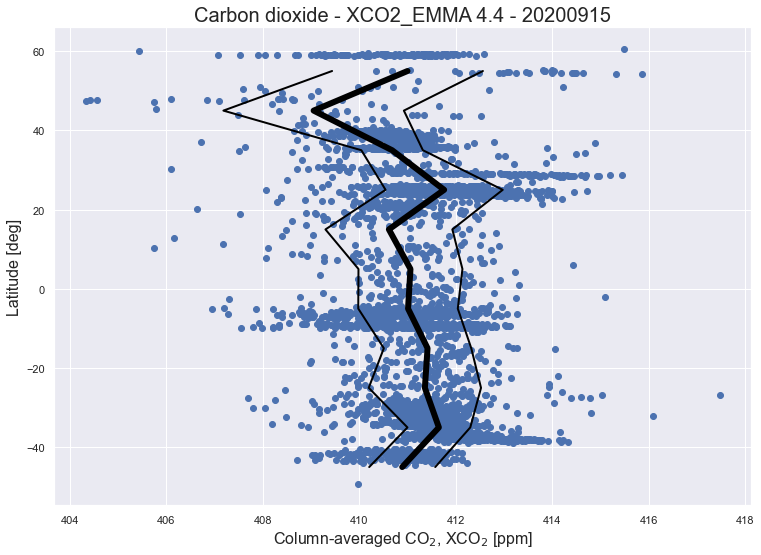

In [7]:
# Plot daily data as a function of latitude

sns.set() # seaborn style for plots
plot_type = 'png'
#plot_type = 'screen'

if 1 == 1:
   if L2_data_OK == 1:
   
      # Compute mean and standard deviation for each latitude band:
      d_lat = 5  # width of lat band in deg: +/- d_lat
      lb_lats    = []
      lb_ghg     = []
      lb_ghg_std = []
      for ii in range(-90+d_lat, 90, d_lat*2):
         act_lat = ii
         idg = np.where((lat > act_lat-d_lat) & (lat < act_lat+d_lat))
         sel = ghg[idg]; len_sel = len(sel)
         #print('* len_sel: ', len_sel)
         lb_lats.append(act_lat)
         if len_sel > 0:
            mean_ghg = np.mean(sel)
            std_ghg  = np.std(sel)
            lb_ghg.append(mean_ghg)
            lb_ghg_std.append(std_ghg)
         else:
            lb_ghg.append(-999.999)
            lb_ghg_std.append(-999.999)
      lb_lats    = np.array(lb_lats)
      lb_ghg     = np.array(lb_ghg)
      lb_ghg_std = np.array(lb_ghg_std)
      idg = np.where(lb_ghg_std > 0)
      lb_lats    = lb_lats[idg]
      lb_ghg     = lb_ghg[idg]
      lb_ghg_std = lb_ghg_std[idg]
   
      # Plot data:
      if 1 == 1:
         xxx = ghg
         yyy = lat
         figsize = (11,8)
         if 1 == 1:
            fig = plt.figure(figsize=figsize)
            pos = [0.09,0.11,0.88,0.83]     # pos (l,b,w,h) in page coord
            ax  = fig.add_axes(pos)
         else:
            fig, ax = plt.subplots(figsize=figsize)
         ax.scatter(xxx, yyy, zorder=10)
         ax.plot(lb_ghg, lb_lats, linewidth=6.0, color='black', zorder=20)
         ax.plot(lb_ghg-lb_ghg_std, lb_lats, linewidth=2.0, color='black', zorder=20) # linestyle='dashed'
         ax.plot(lb_ghg+lb_ghg_std, lb_lats, linewidth=2.0, color='black', zorder=20)
         title = xghg_str+' - '+product_str+' - '+date_str
         x_label = xghg_str2
         y_label = 'Latitude [deg]'
         plt.title(title, fontsize=20)
         plt.xlabel(x_label, fontsize=16); plt.ylabel(y_label, fontsize=16)
         if plot_type == 'png':
            o_file_plot = product_id+'_latitude.png'
            print('* generating: ', o_file_plot)
            plt.savefig(o_file_plot, dpi=600)
         else:
            plt.show()
   else:
      print('* Warning: No data for latitude plot')

## Plot data on a map:

* generating:  XCO2_EMMA_map.png


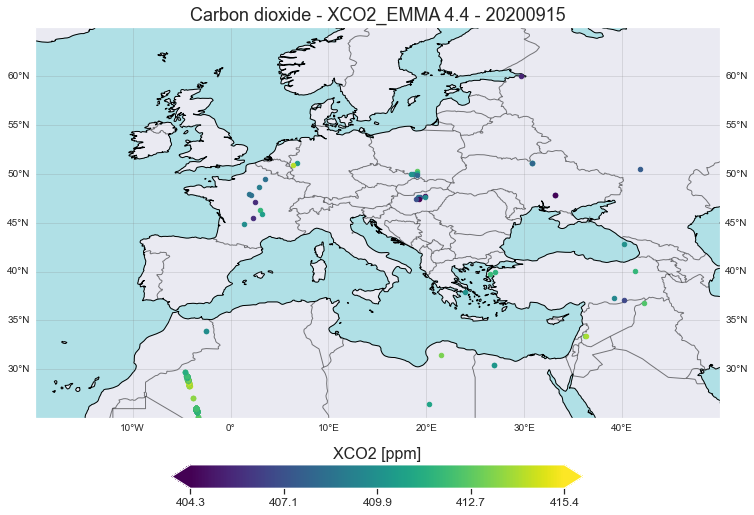

In [8]:
# Define spatial region of interest:
if 1 == 1:
   lonmin = -20.0
   lonmax =  50.0
   latmin =  25.0
   latmax =  65.0
if 1 == 0:
   lonmin = -177.0
   lonmax =  177.0
   latmin = -85.0
   latmax =  85.0
if product_id == 'CO2_AIR_NLIS':
   lonmin = -130.0
   lonmax =  130.0
   latmin = -50.0
   latmax =  50.0
   
if L2_data_OK == 1:
   
   # Select data for spatial region of interest:
   idg = np.where((lat > latmin) & (lat < latmax) & (lon > lonmin) & (lon < lonmax))
   len_idg = len(idg[0])
   
   do_use_all = 0
   if (len_idg == 0):
      print('* Warning: no data found for map for region of interest')
      print('*          ... plotting global data ...')
      if 1 == 1:
         do_use_all = 1
         if 1 == 1:
            lonmin = -180.0
            lonmax =  180.0
            latmin = -90.0
            latmax =  90.0
      
if L2_data_OK == 1:
      
   if do_use_all == 0:
      lat_sel = lat[idg] 
      lon_sel = lon[idg] 
      ghg_sel = ghg[idg] 
   else:
      lat_sel = lat
      lon_sel = lon
      ghg_sel = ghg

   # Plot title:
   title = xghg_str+' - '+product_str+' - '+date_str

   if 1 == 1:
      if 1 == 1:
         rmin  = np.min(ghg_sel)
         rmax  = np.max(ghg_sel)
         ndata = len(ghg_sel)
         if 1 == 1:
            pass
            projection = ccrs.PlateCarree()
            #figsize = (8,5)
            figsize = (12,8)
            if 1 == 0:
               fig = plt.figure(figsize=figsize)
               nc_rows = 1; nc_cols = 1
               ax1 = fig.add_subplot(nc_rows, nc_cols, 1, projection=projection)
            else:
               fig = plt.figure(figsize=figsize)
               pos = [0.08,0.25,0.84,0.68]     # pos (l,b,w,h) in page coord
               ax1 = fig.add_axes(pos, projection=projection)
            ax1.set_extent([lonmin, lonmax, latmin, latmax], crs=projection)
            ax1.add_feature(cfeature.OCEAN, color='powderblue')
            ax1.add_feature(cfeature.COASTLINE)
            ax1.add_feature(cfeature.BORDERS, alpha=0.5)
            x_label = 'Latitude [deg]'
            y_label = 'Longitude [deg]'
            ax1.set_title(title, fontsize=18)
            drawmeridians_label = True
            gl = ax1.gridlines(crs=projection, draw_labels=drawmeridians_label, linewidth=1, color='gray', alpha=0.2)
            #gl.xlabels_top = False
            gl.top_labels  = False
            # ----------------------------------------
            # Set colors:
            cp_name = 'viridis'
            scmap   = plt.get_cmap(cp_name)
            colors  = scmap.colors        
            cc_all = mb_set_colors(colors, rmin, rmax, ghg_sel)
            # ----------------------------------------
            if 1 == 1:
               for ii in range(ndata):
                  act_lat   = lat_sel[ii]
                  act_lon   = lon_sel[ii]
                  act_color = cc_all[ii]
                  #max_area = 40.0
                  #act_area =  data[ii]/rmax * max_area
                  act_area = 20.0
                  zorder_data = 100
                  alpha = 1.0
                  if 1 == 1:
                     if act_area >= 0:
                        ax1.scatter(act_lon, act_lat, color=act_color, s=act_area, cmap=cp_name, zorder=zorder_data, alpha=alpha)
               # ----------------------------------------
               do_cb = 1    # Add color bar
               if do_cb == 1:                 
                  orientation='horizontal'
                  cb_scale_y  = 2.0
                  cb_cy_shift = +0.05
                  axpos = ax1.get_position()
                  cax_width  = 0.60*axpos.width
                  cax_height = 0.03*axpos.height * cb_scale_y
                  pos_x = axpos.x0 + 0.20*axpos.width
                  pos_y = axpos.y0 - 4.2*cax_height + cb_cy_shift
                  pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
                  pos_cax.set_title(main_product+' ['+xghg_unit+']', fontsize=16)
                  cb_extend = 'both'
                  norm=mpl.colors.Normalize(vmin=rmin, vmax=rmax)
                  dr = (rmax-rmin)/4.0
                  bounds = [rmin, rmin+1*dr, rmin+2*dr, rmin+3*dr, rmin+4*dr]
                  bounds_str = np.char.mod('%.1f', bounds)
                  cb1 = mpl.colorbar.ColorbarBase(pos_cax, cmap=cp_name, norm=norm, 
                            orientation=orientation, extend=cb_extend, ticks=bounds)
                  cb1.ax.set_xticklabels(bounds_str, fontsize=12)
               # ----------------------------------------
            if plot_type == 'png':
               o_file_plot = product_id+'_map.png'
               print('* generating: ', o_file_plot)
               plt.savefig(o_file_plot, dpi=600)
            else:
               plt.show()
      else:
         print('* Warning: No data for map (1) !')
   else:
      print('* Warning: No data for map (2) !')
else:
   print('* Warning: No data for map (3) !')

## Plot a priori profile and averaging kernel:

* n_data:  5455
* Selected ground pixel: index:  2370
* lat lon ghg:  30.449978 26.900187 410.57593
* pre_lev.shape:  (5455, 11)
* gas_apri.shape:  (5455, 10)
* gas_ak.shape:  (5455, 10)
* generating:  XCO2_EMMA_ak.png


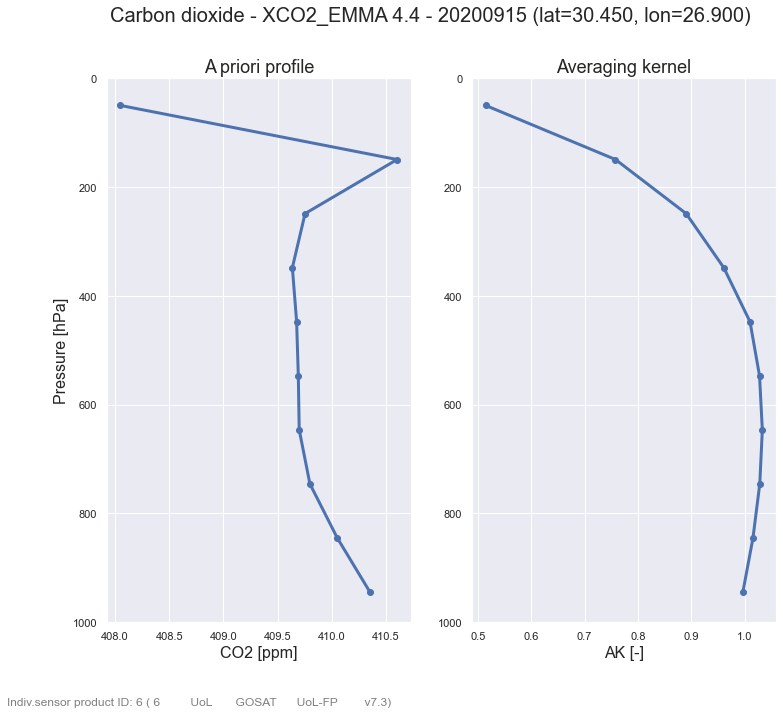

In [9]:
# Plot a priori profile and averaging kernel for one selected ground pixel

if 1 == 1:
   if L2_data_OK == 1:
      title = title = xghg_str+' - '+product_str+' - '+date_str
      n_data = len(ghg)
      print('* n_data: ', n_data)
      grd_px_OK = 0
      if n_data <= 0:
         print('* Warning: No data for averaging kernel plot')
      else:
         if 1 == 0:
            grd_px_idx = int(n_data / 2)
            #grd_px_idx = 900
         else:
            # Define region of interest:
            if 1 == 1:
               idx_px = np.where((lat > 25.0) & (lat < 35.0) & (lon > -10.0) & (lon < 30.0)) # Northern Africa
            if 1 == 0:
               la_c = 30.450; lo_c = 26.900; dd = 0.1  
               idx_px = np.where((lat > la_c-dd) & (lat < la_c+dd) & (lon > lo_c-dd) & (lon < lo_c+dd)) # Test
            # idx_px: tuple object
            #grd_px_idx = idx_px[0][0]
            # May happen: IndexError: index 0 is out of bounds for axis 0 with size 0
            #if any(idx_px) == True:
            len_idx_px = len(idx_px[0])
            #print('* len_idx_px: ', len_idx_px)
            if len_idx_px > 0:
               grd_px_idx = idx_px[0][0]
               grd_px_OK = 1
            else:
               #grd_px_OK = 0
               print('* Warning: No ground pixel found for averaging kernel plot for region of interest')
               len_lat = len(lat)
               if len_lat > 0:
                  grd_px_idx = int(n_data / 2)
                  if grd_px_idx < 0:
                     grd_px_idx = 0
               print('           Using data for other region ...')
               grd_px_OK = 1
      if grd_px_OK == 0:
         print('* Warning: No ground pixel found for averaging kernel plot')
      if ((1 == 1) & (grd_px_OK == 1)): 
         print('* Selected ground pixel: index: ', grd_px_idx)
         act_lat = lat[grd_px_idx]
         act_lon = lon[grd_px_idx]
         act_ghg = ghg[grd_px_idx]
         act_emma_pro_id = emma_pro_id[grd_px_idx]
         act_emma_pro_id_str = str(act_emma_pro_id)
         print('* lat lon ghg: ', act_lat, act_lon, act_ghg)
         act_lat_str = '{:.3f}'.format(act_lat)
         act_lon_str = '{:.3f}'.format(act_lon)
         sub_title = title+' (lat='+act_lat_str+', lon='+act_lon_str+')'
         if 1 == 1:
            print('* pre_lev.shape: ', pre_lev.shape)
            print('* gas_apri.shape: ', gas_apri.shape)
            print('* gas_ak.shape: ', gas_ak.shape)
         p_apri  = gas_apri[grd_px_idx, :]
         p_ak    = gas_ak[grd_px_idx, :]
         p_press = pre_lev[grd_px_idx, :]
         n_lay     = len(p_apri)  # layer (m)
         n_mpx     = len(p_press) # level (m+1) or layer (m) 
         if n_mpx > n_lay:
            p_press_tmp1 = p_press[0:n_lay]
            p_press_tmp2 = p_press[1:n_lay+1]
            p_press = 0.5*(p_press_tmp1 + p_press_tmp2)
         if 1 == 0:
            p_press = np.flip(p_press)
            p_apri  = np.flip(p_apri)
            p_ak    = np.flip(p_ak)
         if 1 == 1:
            # --------------------------------------------
            figsize = (12, 10)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            fig.suptitle(sub_title, fontsize=20)
            if prod_format != 'cci_iasi':
               ax1.plot(p_apri, p_press, linewidth=3.0)
               ax1.scatter(p_apri, p_press)
            else:
               plt.text(0.2, 0.5, 'No profile available', fontsize=10, color='grey', transform=fig.transFigure)
            ax2.plot(p_ak,   p_press, linewidth=3.0)
            ax2.scatter(p_ak,   p_press)
            ax1.set_ylim(1000, 0)
            ax2.set_ylim(1000, 0)
            ax1.set_title('A priori profile', fontsize=18)
            ax1.set_ylabel('Pressure [hPa]', fontsize=16)
            ax1.set_xlabel(xghg_str3+' ['+xghg_unit+']', fontsize=16)
            ax2.set_title('Averaging kernel', fontsize=18)
            ax2.set_xlabel('AK [-]', fontsize=16)
            if ((product_id == 'XCO2_EMMA') | (product_id == 'XCH4_EMMA')):
               p1 = emma_pro_str.find(' '+act_emma_pro_id_str+' ')
               s1 = emma_pro_str[p1:p1+70]
               p2 = s1.find('\r\n')
               s2 = s1[0:p2]
               plt.text(0.01, 0.01, 'Indiv.sensor product ID: '+act_emma_pro_id_str+' ('+s2+')', fontsize=12, color='grey', transform=fig.transFigure)
            if plot_type == 'png':
               o_file_plot = product_id+'_ak.png'
               print('* generating: ', o_file_plot)
               plt.savefig(o_file_plot, dpi=600)
            else:
               plt.show()
            # --------------------------------------------
   else:
      print('* Warning: No data for averaging kernel plot')